In [ ]:
# from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import pandas as pd
from scipy.optimize import fsolve
from scipy.integrate import quad
from scipy.stats import gaussian_kde
from scipy.optimize import root_scalar
from scipy.stats import multivariate_normal
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score

In [2]:
#HRD_scores_pan_cancer = pd.read_csv('../../HRD_score/data/HRD_scores_pan_cancer_annotated_typecorrect.csv', sep=',', header = 0)
#HRD_scores_pan_cancer_primary = HRD_scores_pan_cancer[HRD_scores_pan_cancer['Type'] == 'Primary']
HRD_scores_pan_cancer = pd.read_csv('../../HRD_score/data/HRD_scores_pan_cancer_annotated_v2.csv', sep=',', header = 0)
HRD_scores_pan_cancer_primary = HRD_scores_pan_cancer[HRD_scores_pan_cancer['Type'] == 'Primary']

# Functions

In [9]:
def gmm_n2_pancancer(data):
    '''
    Runs the gaussian mixture model for each cancer type in the pan cancer cohort and saves the results in a dataframe
    Input:
    data (dataframe): HRD results, the rows are different samples and the columns contains information about the sample as well as the the 4 HRD scores
    Output:
    df (dataframe): Cotains the results from the GMM (columns) for all cohorts (rows). The columns include the total number of cases per cohort and the number of case per type (HRD-high or HRD-low)
    
    '''
    
    df = pd.DataFrame(columns=['Project ID','n_cases', 'n2_cutoff', 'n2_likelihood', 'n2_aic', 'n2_bic','n2_n_high','n2_n_low','n2_silhouette_coef'])
    types = np.unique(data['Project ID'])

    for cancer_type in types:
        
        ## Run GMM
        sub_data = data[data['Project ID'] == cancer_type]
        results = gmm_cutoff_n2_v3(sub_data)
        
        ## Get the number of samples per type
        cutoff = results['n2_cutoff']
        high = sub_data[sub_data['HRD_sum']>=cutoff]
        low = sub_data[sub_data['HRD_sum']<cutoff]
        
        df.loc[len(df)] = [cancer_type, sub_data.shape[0], results['n2_cutoff'], results['n2_likelihood'], results['n2_aic'], results['n2_bic'], high.shape[0], low.shape[0],results['n2_silhouette_coef']]
        
    return df


def gmm_cutoff_n2(data):
    
    '''
    Constructs a Gaussian Mixture Model with 2 components. Gives back the model metrics and the HRDsum cutoff between the two labels.
    Input:
    data (dataframe): HRD results, the rows are different samples and the columns contains information about the sample as well as the the 4 HRD scores
    Output:
    results (dictionary): Results contains 5 keys, does are n2_likelihood (loglikelihood), n2_aic (AIC), n2_bic (BIC), n2_silhouette_coef (avg. silhouette coef.) and n2_cutoff (cutoff value between HRD-high and HRD-low)
    
    '''
    
    ## Get the HRDsum
    data = data[['Sample ID','HRD_sum']]
    data.set_index('Sample ID', inplace = True)
    
    ## Variables prepareation
    data_local = data.copy()
    results = dict()
    minimums = []
    
    ## Gaussian mixture model fitting and assigning labels to each data point
    ## Max_iter and n_init were test on different parameters, with no differencee shwoing
    np.random.seed(42)
    gmm = GaussianMixture(n_components=2,max_iter = 1000, n_init = 10)
    gmm.fit(data_local)
    labels = gmm.predict(data_local)
    silhouette_coef = silhouette_score(data_local, labels)
    
    
    ## Predict vector with values from 0 to max(HRDsum) to get the cutoffs
    max_number = int(max(list(data_local['HRD_sum'])))
    vector = np.arange(max_number + 1).reshape(-1, 1)
    labels = gmm.predict(vector).reshape(-1, 1)

    
    vector_lables = np.hstack((vector, labels))
    
    first_column = vector_lables[:, 0]
    second_column = vector_lables[:, 1]

    # Find the minimum value for each label
    min_values = [np.min(first_column[second_column == label]) for label in np.unique(second_column)]
    
    ## Save statistics
    results['n2_likelihood'] = gmm.score(data_local)
    results['n2_aic'] = gmm.aic(data_local)
    results['n2_bic'] = gmm.bic(data_local)
    results['n2_silhouette_coef'] = silhouette_coef
    
    ## Extract cutoff

    results['n2_cutoff'] = max(min_values)

    

    return results

def gmm_n3_pancancer(data):
    '''
    Runs the gaussian mixture model for each cancer type in the pan cancer cohort and saves the results in a dataframe
    Input:
    data (dataframe): HRD results, the rows are different samples and the columns contains information about the sample as well as the the 4 HRD scores
    Output:
    df (dataframe): Cotains the results from the GMM (columns) for all cohorts (rows). The columns include the total number of cases per cohort and the number of case per type (HRD-high, HRD-low, HRD-medium)
    '''
    

    df = pd.DataFrame(columns=['Project ID','n_cases', 'n3_cutoff_lm','n3_cutoff_mh', 'n3_likelihood', 'n3_aic', 'n3_bic','n_3_n_high','n3_n_medium','n3_n_low','n3_silhouette_coef'])
    types = np.unique(data['Project ID'])
    
    
    for cancer_type in types:
        
        ## Run GMM
        sub_data = data[data['Project ID'] == cancer_type]
        results = gmm_cutoff_n3(sub_data)
        
        ## Extract number of sample per type (high, medium, low)
        cutoff_lm = results['n3_cutoff_lm']
        cutoff_mh = results['n3_cutoff_mh']
        high = sub_data[sub_data['HRD_sum']>=cutoff_mh]
        low = sub_data[sub_data['HRD_sum']<cutoff_lm]
        medium = sub_data[(sub_data['HRD_sum']<cutoff_mh) & (sub_data['HRD_sum']>=cutoff_lm)]
        df.loc[len(df)] = [cancer_type, sub_data.shape[0], results['n3_cutoff_lm'], results['n3_cutoff_mh'], results['n3_likelihood'], results['n3_aic'], results['n3_bic'], high.shape[0], medium.shape[0], low.shape[0],results['n3_silhouette_coef']]
    return df


def gmm_cutoff_n3(data):
    
    '''
    Constructs a Gaussian Mixture Model with 3 components. Gives back the model metrics and the HRDsum cutoff between the two labels.
    Input:
    data (dataframe): HRD results, the rows are different samples and the columns contains information about the sample as well as the the 4 HRD scores
    Output:
    results (dictionary): Results contains 6 keys, does are n3_likelihood (loglikelihood), n3_aic (AIC), n3_bic (BIC), n3_silhouette_coef (avg. silhouette coef.), n3_cutoff_lm (cutoff value between HRD-low and HRD-medium)
    and n3_cutoff_mh (cutoff value between HRD-medium and HRD-high)
    
    '''
    
    ## Get HRDsum score
    data = data[['Sample ID','HRD_sum']]
    data.set_index('Sample ID', inplace = True)
    
    ## Prepare variables
    data_local = data.copy()
    results = dict()
    minimums = []
    
    ## Run GMM, fit the data and get the labels for each data point
    np.random.seed(42)
    gmm = GaussianMixture(n_components=3,max_iter = 1000, n_init = 10)
    gmm.fit(data_local)
    labels = gmm.predict(data_local)
    silhouette_coef = silhouette_score(data_local, labels)
    
    ## Get statisitcs
    results['n3_likelihood'] = gmm.score(data_local)
    results['n3_aic'] = gmm.aic(data_local)
    results['n3_bic'] = gmm.bic(data_local)
    results['n3_silhouette_coef'] = silhouette_coef
    
    ## Predict vector with values from 0 to max(HRDsum) to get the cutoffs
    max_number = int(max(list(data_local['HRD_sum'])))
    vector = np.arange(max_number + 1).reshape(-1, 1)
    labels = gmm.predict(vector).reshape(-1, 1)
    
    vector_lables = np.hstack((vector, labels))
    
    first_column = vector_lables[:, 0]
    second_column = vector_lables[:, 1]

    # Find the minimum value for each label
    min_values = [np.min(first_column[second_column == label]) for label in np.unique(second_column)]
    
    
    
    min_values.sort()
    results['n3_cutoff_lm'] = min_values[-2]
    results['n3_cutoff_mh'] = min_values[-1]

    return results



def analyseStatistics(data):
        '''
    Function that runs the GMM for all cohorts with 2 to 6 components and saves the statsitics (loglikelihood, AIC, BIC, avg. silhouette coef.).
    Input:
    data (dataframe): HRD results, the rows are different samples and the columns contains information about the sample as well as the the 4 HRD scores
    Output:
    df (dataframe): Containg all the results for each cohort for each number of clusters (rows are the different cohorts, columns are the different metrics)
    '''
    df = pd.DataFrame(columns = ['Project ID', 'n2_aic', 'n3_aic', 'n4_aic', 'n5_aic', 'n6_aic', 'n2_bic', 'n3_bic', 'n4_bic', 'n5_bic', 'n6_bic', 'n2_log', 'n3_log', 'n4_log', 'n5_log', 'n6_log','n2_sil','n3_sil','n4_sil','n5_sil','n6_sil'])
    types = np.unique(data['Project ID'])
    n_comp = [2,3,4,5,6]
    
    for cancer_type in types:
        ## Subset data for a single cohort
        results_type = dict()
        sub_data = data[data['Project ID'] == cancer_type]
        sub_data = sub_data[['Sample ID','HRD_sum']]
        sub_data.set_index('Sample ID', inplace = True)
        for n in n_comp:
            ## Run GMM for n_component = 2 to 6 and save the different metrics
            np.random.seed(42)
            gmm = GaussianMixture(n_components=n,max_iter = 1000, n_init = 10).fit(sub_data)
            labels = gmm.predict(sub_data)
            silhouette_coef = silhouette_score(sub_data, labels)
            results_type[str(n)+'_log'] = gmm.score(sub_data)
            results_type[str(n)+'_aic'] = gmm.aic(sub_data)
            results_type[str(n)+'_bic'] = gmm.bic(sub_data)
            results_type[str(n)+'_sil'] = silhouette_coef
            print('Finished analysis for n_comp = '+ str(n) + ' for cohort '+ cancer_type)
        df.loc[len(df)] = [cancer_type, results_type['2_aic'], results_type['3_aic'], results_type['4_aic'], results_type['5_aic'], results_type['6_aic'], results_type['2_bic'], results_type['3_bic'], results_type['4_bic'], results_type['5_bic'], results_type['6_bic'], results_type['2_log'], results_type['3_log'], results_type['4_log'], results_type['5_log'], results_type['6_log'], results_type['2_sil'], results_type['3_sil'], results_type['4_sil'], results_type['5_sil'], results_type['6_sil']]
        print('Finished cohort '+ cancer_type)
    df.to_csv('../data/gmm_components_analysis_v2.csv', sep=',', header = True)
    
    return df


    
def testparameter(data, max_iter, n_init, random = True):
    '''
    Use for testing the Gaussian Mixture models parameters (max_iter, n_init) and random.seed
    '''
    data = data[['Sample ID','HRD_sum']]
    data.set_index('Sample ID', inplace = True)
    
    
    data_local = data.copy()
    results = dict()
    minimums = []
    
    if not random:
        np.random.seed(42)
    gmm = GaussianMixture(n_components=2,max_iter = max_iter, n_init = n_init)
    gmm.fit(data_local)
    labels = gmm.predict(data_local)
    
    results['n2_likelihood'] = gmm.score(data_local)
    results['n2_aic'] = gmm.aic(data_local)
    results['n2_bic'] = gmm.bic(data_local)
    
    data_local['labels'] = labels
    minimums.append(min(data_local[data_local['labels'] == 0]['HRD_sum']))
    minimums.append(min(data_local[data_local['labels'] == 1]['HRD_sum']))
    results['n2_cutoff'] = max(minimums)

    

    return results

def loadData(path_data_file):
    '''
    Loads the data and subset it to only extract the primary type.
    Input:
    path_data_file (string): Full path and name of the datafile containing at least the columns (Project ID, HRD_sum, Type)
    Output:
    primary (dataframe): Data containing only the primary sample type
    '''
    HRD_pan_cancer = pd.read_csv(path_data_file, sep=',', header = 0)
    primary = HRD_pan_cancer[HRD_pan_cancer['Type'] == 'Primary']
    
    return primary

def runGMMCutoff(mode, path_data_file, path_results, filename = 'GMM_cutoff_pancancer'):
    '''
    Runs GMM to infer cutoff.
    Input:
    mode (string): Indicates the number of components 'n2' for 2 clusters (low and high), 'n3' for 3 components (low, medium, high) or 'both' to get the results for 2 and 3 components
    path_data_file (string): Full path and name of the datafile containing at least the columns (Project ID, HRD_sum, Type)
    path_results (string): Path to the folder where the output should be saved
    filename (string): Name of the outputfile (default: GMM_cutoff_pancancer)
    '''
    data = loadData(path_data_file)
    
    if mode == 'n2':
        results_n2 = runKmeans_pancancer_n2(data)
        results_n2.to_csv(path_results + '/' + mode+ '_' + filename, sep=',', header = True)
    elif mode == 'n3':
        results_n3 = runKmeans_pancancer_n3(data)
        results_n3.to_csv(path_results + '/' + mode + '_' + filename, sep=',', header = True)
    else:
        results_n2 = runKmeans_pancancer_n2(data)
        results_n3 = runKmeans_pancancer_n3(data)
        results = pd.merge(results_n2, results_n3, on=['Project ID','n_cases'])
        results.to_csv(path_results + '/' + filename + 'csv', sep=',', header = True)
        





# Run GMM cutoffs

In [ ]:
runGMMCutoff(mode = 'both', path_data_file = '../../HRD_score/data/HRD_scores_pan_cancer_annotated_v2.csv', path_results = '../data', filename = 'GMM_cutoff_pancancer')

# 2 and 3 components GMM

In [48]:
results_n2 = gmm_n2_pancancer(HRD_scores_pan_cancer_primary)
results_n3 = gmm_n3_pancancer(HRD_scores_pan_cancer_primary)

In [54]:
results = pd.merge(results_n2, results_n3, on=['Project ID','n_cases'])

In [55]:
results.to_csv('../data/gmm_cutoffs_pancancer.csv', sep=',', header = True)

# New version

In [11]:
results_n2 = gmm_n2_pancancer(HRD_scores_pan_cancer_primary)
results_n3 = gmm_n3_pancancer(HRD_scores_pan_cancer_primary)

/home/USZ/plialacc/Storage/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/home/USZ/plialacc/Storage/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/home/USZ/plialacc/Storage/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/home/USZ/plialacc/Storage/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/home/USZ/plialacc/Storage/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  

/home/USZ/plialacc/Storage/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/home/USZ/plialacc/Storage/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/home/USZ/plialacc/Storage/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/home/USZ/plialacc/Storage/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/home/USZ/plialacc/Storage/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  

In [12]:
results = pd.merge(results_n2, results_n3, on=['Project ID','n_cases'])

In [13]:
results.to_csv('../data/gmm_cutoffs_pancancer_v3.csv', sep=',', header = True)

## Testing Statisic analysis

In [10]:
results = analyseStatistics(HRD_scores_pan_cancer_primary)

Finished analysis for n_comp = 2 for cohort TARGET-ALL-P2
Finished analysis for n_comp = 3 for cohort TARGET-ALL-P2
Finished analysis for n_comp = 4 for cohort TARGET-ALL-P2
Finished analysis for n_comp = 5 for cohort TARGET-ALL-P2
Finished analysis for n_comp = 6 for cohort TARGET-ALL-P2
Finished cohort TARGET-ALL-P2
Finished analysis for n_comp = 2 for cohort TARGET-AML
Finished analysis for n_comp = 3 for cohort TARGET-AML
Finished analysis for n_comp = 4 for cohort TARGET-AML
Finished analysis for n_comp = 5 for cohort TARGET-AML
Finished analysis for n_comp = 6 for cohort TARGET-AML
Finished cohort TARGET-AML
Finished analysis for n_comp = 2 for cohort TARGET-CCSK
Finished analysis for n_comp = 3 for cohort TARGET-CCSK
Finished analysis for n_comp = 4 for cohort TARGET-CCSK
Finished analysis for n_comp = 5 for cohort TARGET-CCSK
Finished analysis for n_comp = 6 for cohort TARGET-CCSK
Finished cohort TARGET-CCSK
Finished analysis for n_comp = 2 for cohort TARGET-OS
Finished analysi

Finished analysis for n_comp = 2 for cohort TCGA-SARC
Finished analysis for n_comp = 3 for cohort TCGA-SARC
Finished analysis for n_comp = 4 for cohort TCGA-SARC
Finished analysis for n_comp = 5 for cohort TCGA-SARC
Finished analysis for n_comp = 6 for cohort TCGA-SARC
Finished cohort TCGA-SARC
Finished analysis for n_comp = 2 for cohort TCGA-SKCM
Finished analysis for n_comp = 3 for cohort TCGA-SKCM
Finished analysis for n_comp = 4 for cohort TCGA-SKCM
Finished analysis for n_comp = 5 for cohort TCGA-SKCM
Finished analysis for n_comp = 6 for cohort TCGA-SKCM
Finished cohort TCGA-SKCM
Finished analysis for n_comp = 2 for cohort TCGA-STAD
Finished analysis for n_comp = 3 for cohort TCGA-STAD
Finished analysis for n_comp = 4 for cohort TCGA-STAD
Finished analysis for n_comp = 5 for cohort TCGA-STAD
Finished analysis for n_comp = 6 for cohort TCGA-STAD
Finished cohort TCGA-STAD
Finished analysis for n_comp = 2 for cohort TCGA-TGCT
Finished analysis for n_comp = 3 for cohort TCGA-TGCT
Fini

# With Plots, Lung Cancer

# LUSC

Label: 0
309
21.0
Label: 1
114
52.0
Label: 2
49
0.0
Label: 0
309
21.0
Label: 1
114
52.0
Label: 2
49
0.0
Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
114
52.0
Label: 1
49
0.0
Label: 2
309
21.0
Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
49
0.0
Label: 1
114
52.0
Label: 2
309
21.0
Label: 0
114
52.0
Label: 1
49
0.0
Label: 2
309
21.0
Label: 0
309
21.0
Label: 1
49
0.0
Label: 2
114
52.0
Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
49
0.0
Label: 1
114
52.0
Label: 2
309
21.0
Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
114
52.0
Label: 1
49
0.0
Label: 2
309
21.0
Label: 0
309
21.0
Label: 1
114
52.0
Label: 2
49
0.0
Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
114
52.0
Label: 1
49
0.0
Label: 2
309
21.0
Label: 0
49
0.0
Label: 1
114
52.0
Label: 2
309
21.0
Label: 0
49


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
309
21.0
Label: 1
49
0.0
Label: 2
114
52.0


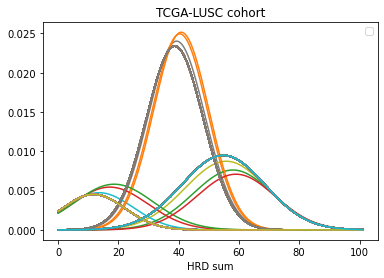

In [13]:
cancer_type = 'TCGA-LUSC'
HRD_scores_pan_cancer_type = HRD_scores_pan_cancer[HRD_scores_pan_cancer['Project ID'] == cancer_type]
HRD_type_primary = HRD_scores_pan_cancer_type[HRD_scores_pan_cancer_type['Type'] == 'Primary']
testing_gmm = HRD_type_primary[['Sample ID','HRD_sum']]
test_all_scores = HRD_type_primary[['Sample ID','HRD_sum','LST','TAI','LOH']]
testing_gmm.set_index('Sample ID', inplace=True)
test_all_scores.set_index('Sample ID', inplace=True)

n = 3
# create a GMM model with 3 components
plt.figure(facecolor=(1, 1, 1))
for i in range(0,100):
    data = testing_gmm.copy()
    #np.random.seed(42)
    gmm = GaussianMixture(n_components=n,max_iter = 1000, n_init = 10)

    # fit the model to the data
    gmm.fit(data)

    # predict the cluster labels for each data point
    labels = gmm.predict(data)

    # get the parameters of each component
    means = gmm.means_
    covariances = gmm.covariances_
    weights = gmm.weights_

    # create a range of values for the x-axis
    x = np.linspace(data.min(), data.max(), 1000)
    # create a plot for each component
    pdf_list = list()
    for i in range(len(weights)):
        # calculate the probability density function for the component
        pdf = weights[i] * np.exp(-(x - means[i])**2 / (2 * covariances[i])) / np.sqrt(2 * np.pi * covariances[i])
        pdf_list.append(pdf)
        # plot the PDF as a curve
        plt.plot(x, pdf)
    data['label'] = labels
    for lab in np.unique(data['label']):
        n_cases = data[data['label'] == lab]
        print('Label: '+str(lab))
        print(n_cases.shape[0])
        print(min(n_cases['HRD_sum']))

plt.xlabel('HRD sum')
plt.title(cancer_type +' cohort')
# display the plot
if n == 2:
    plt.savefig("../data/GMM_n2_LUSC.png", bbox_inches='tight')
else:
    plt.savefig("../data/GMM_n3_LUSC.png", bbox_inches='tight')

# LUAD

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


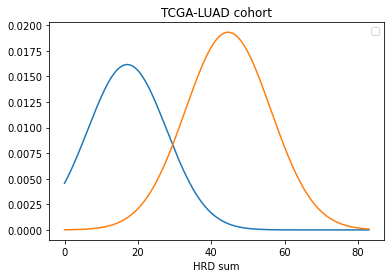

In [16]:
cancer_type = 'TCGA-LUAD'
HRD_scores_pan_cancer_type = HRD_scores_pan_cancer[HRD_scores_pan_cancer['Project ID'] == cancer_type]
HRD_type_primary = HRD_scores_pan_cancer_type[HRD_scores_pan_cancer_type['Type'] == 'Primary']
testing_gmm = HRD_type_primary[['case_id','HRD_sum']]
test_all_scores = HRD_type_primary[['case_id','HRD_sum','LST','TAI','LOH']]
testing_gmm.set_index('case_id', inplace=True)
test_all_scores.set_index('case_id', inplace=True)

n = 2

# create a GMM model with 3 components
plt.figure(facecolor=(1, 1, 1))
for i in range(0,1):
    data = testing_gmm.copy()
    np.random.seed(42)
    gmm = GaussianMixture(n_components=n,max_iter = 1000, n_init = 10)

    # fit the model to the data
    gmm.fit(data)

    # predict the cluster labels for each data point
    labels = gmm.predict(data)

    # get the parameters of each component
    means = gmm.means_
    covariances = gmm.covariances_
    weights = gmm.weights_

    # create a range of values for the x-axis
    x = np.linspace(data.min(), data.max(), 1000)
    # create a plot for each component
    pdf_list = list()
    for i in range(len(weights)):
        # calculate the probability density function for the component
        pdf = weights[i] * np.exp(-(x - means[i])**2 / (2 * covariances[i])) / np.sqrt(2 * np.pi * covariances[i])
        pdf_list.append(pdf)
        # plot the PDF as a curve
        plt.plot(x, pdf)
    data['label'] = labels
    #for lab in np.unique(data['label']):
       # n_cases = data[data['label'] == lab]
        #print('Label: '+str(lab))
       # print(n_cases.shape[0])

plt.xlabel('HRD sum')
plt.title(cancer_type +' cohort')
# display the plot
if n == 2:
    plt.savefig("../data/GMM_n2_LUAD.png", bbox_inches='tight')
else:
    plt.savefig("../data/GMM_n3_LUAD.png", bbox_inches='tight')

# HNSC

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


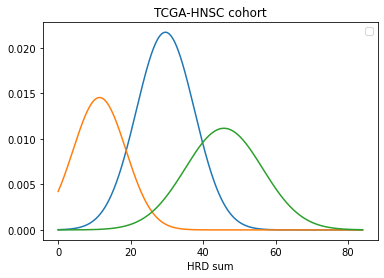

In [18]:
cancer_type = 'TCGA-HNSC'
HRD_scores_pan_cancer_type = HRD_scores_pan_cancer[HRD_scores_pan_cancer['Project ID'] == cancer_type]
HRD_type_primary = HRD_scores_pan_cancer_type[HRD_scores_pan_cancer_type['Type'] == 'Primary']
testing_gmm = HRD_type_primary[['case_id','HRD_sum']]
test_all_scores = HRD_type_primary[['case_id','HRD_sum','LST','TAI','LOH']]
testing_gmm.set_index('case_id', inplace=True)
test_all_scores.set_index('case_id', inplace=True)

n = 3
# create a GMM model with 3 components
plt.figure(facecolor=(1, 1, 1))
for i in range(0,1):
    data = testing_gmm.copy()
    np.random.seed(42)
    gmm = GaussianMixture(n_components=n,max_iter = 1000, n_init = 10)

    # fit the model to the data
    gmm.fit(data)

    # predict the cluster labels for each data point
    labels = gmm.predict(data)

    # get the parameters of each component
    means = gmm.means_
    covariances = gmm.covariances_
    weights = gmm.weights_

    # create a range of values for the x-axis
    x = np.linspace(data.min(), data.max(), 1000)
    # create a plot for each component
    pdf_list = list()
    for i in range(len(weights)):
        # calculate the probability density function for the component
        pdf = weights[i] * np.exp(-(x - means[i])**2 / (2 * covariances[i])) / np.sqrt(2 * np.pi * covariances[i])
        pdf_list.append(pdf)
        # plot the PDF as a curve
        plt.plot(x, pdf)
    data['label'] = labels
    #for lab in np.unique(data['label']):
       # n_cases = data[data['label'] == lab]
        #print('Label: '+str(lab))
       # print(n_cases.shape[0])

plt.xlabel('HRD sum')
plt.title(cancer_type +' cohort')

# display the plot
if n == 2:
    plt.savefig("../data/GMM_n2_HNSC.png", bbox_inches='tight')
else:
    plt.savefig("../data/GMM_n3_HNSC.png", bbox_inches='tight')